In [1]:
import pandas as pd
import texthero as hero
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

Making the edition an integer type

In [2]:
df = pd.read_csv("RNA Timeline - Primary sources.csv")
df["Edition"] = df["Edition"].fillna(1).astype(int)

Preprocessing book titles

In [3]:
custom_stopwords = hero.stopwords.DEFAULT.union(stopwords.words("german"))
df["Title_nostopwords"] = hero.remove_stopwords(df["Book"].str.lower(), custom_stopwords)
df["Title_nostopwords"] = hero.remove_diacritics(df["Title_nostopwords"])
df["Author_nodiacritics"] = hero.remove_diacritics(df["Author"])

In [4]:
with open("primary_sources.bib", "w") as bibfile:
    for idx, row in df.iterrows():
        mainauthorid = row['Author_nodiacritics'].split(",")[0].lower()
        mainauthorid = mainauthorid.replace("-", "").replace(" ", "")
        titleid = row['Title_nostopwords'].split()[0].lower()
        identifier = f"{mainauthorid}{row['Year']}{titleid}"
        bibtex = f"""@book{{{identifier},
        title = {{{row['Book'].title()}}},
        author = {{{row['Author']}}},
        year = {{{row['Year']}}},
        edition = {{{row['Edition']}}},
        keywords = {{PhDThesis_Background_PrimarySource}},"""
        if isinstance(row["notes_1"], str):
            for annotation in row["notes_1"].split("; "):
                bibtex += f"""
        annote = {{{annotation}}},"""
        bibtex += "\n}\n\n"
        print(bibtex)
        bibfile.write(bibtex)

@book{kirnberger1774kunst,
        title = {Die Kunst Des Reinen Satzes In Der Musik},
        author = {Kirnberger, Johann Philipp},
        year = {1774},
        edition = {1},
        keywords = {PhDThesis_Background_PrimarySource},
}


@book{vogler1778grunde,
        title = {Gründe Der Kuhrpfälzischen Tonschule},
        author = {Vogler, Georg Joseph},
        year = {1778},
        edition = {1},
        keywords = {PhDThesis_Background_PrimarySource},
}


@book{vogler1802handbuch,
        title = {Handbuch Zur Harmonielehre Und Für Den Generalbaß},
        author = {Vogler, Georg Joseph},
        year = {1802},
        edition = {1},
        keywords = {PhDThesis_Background_PrimarySource},
}


@book{weber1817versuch,
        title = {Versuch Einer Geordneten Theorie Der Tonsetzkunst},
        author = {Weber, Gottfried},
        year = {1817},
        edition = {1},
        keywords = {PhDThesis_Background_PrimarySource},
        annote = {s.201: Multilayered RN analysis},
   

In [21]:
with open("primary_sources_table.tex", "w") as latextable:
    header = r"""\begin{table}
\centering
\footnotesize
\begin{tabular}{l l l} 
"""
    latextable.write(header)
    cols = 3
    for idx, row in df.iterrows():
        mainauthorid = row['Author_nodiacritics'].split(",")[0].lower()
        mainauthorid = mainauthorid.replace("-", "").replace(" ", "")
        titleid = row['Title_nostopwords'].split()[0].lower()
        identifier = f"{mainauthorid}{row['Year']}{titleid}"
        identifier = identifier.replace(":", "").replace("-", "").replace("'", "s").replace("modulate", "how")
        if idx % cols == (cols - 1):
            row = f"\\textcite{{{identifier}}} \\\\\n"
        else:
            row = f"\\textcite{{{identifier}}} & "
        latextable.write(row)
    footer = r"""\end{tabular}
\caption{All primary sources reviewed in terms of their Roman numeral analysis syntax.}
\label{tab:primsources}
\end{table}"""
    latextable.write(footer)

Plotting a timeline

In [6]:
# Getting non-null entries
# dfnotnull = df[df['Roman numerals?'].notnull()]
# df["RN1"] = [True if x=="Yes" else False for x in df["Roman numerals?"]]
dfdict = {
    "period": [],
    "figured_bass": [],
    "roman_numerals": [],
}
for rangestart in range(1770, 1970, 10):
    rangeend = rangestart + 10
    rangedf = df[(df["Year"] >= rangestart) & (df["Year"] < rangeend)]
    rangedf = rangedf[(rangedf["fb_occurrence (0=none 1=rare 2=occasional 3=common 4=dense)"].notna()) & (rangedf["rn_occurrence? (0=none 1=rare 2=occasional 3=common 4=dense)"].notna())]
    books = len(rangedf.index)
    maxOccurrence = 3.0
    fb = rangedf["fb_occurrence (0=none 1=rare 2=occasional 3=common 4=dense)"] > 0
    rn = rangedf["rn_occurrence? (0=none 1=rare 2=occasional 3=common 4=dense)"] > 0
    fbscore = fb.sum()
    rnscore = rn.sum()
#     print(fb.to_list(), fbscore, rn.to_list(), rnscore)
    print(fbscore, rnscore)
    dfdict["period"].append(f"{rangestart}\n{rangeend}")
    dfdict["figured_bass"].append(fbscore)
    dfdict["roman_numerals"].append(rnscore)
dfplot = pd.DataFrame(dfdict)

2 2
0 0
0 0
1 1
0 1
1 0
0 0
2 1
4 2
4 1
4 4
8 6
12 8
7 11
13 15
10 9
2 3
1 1
0 0
3 4


[Text(0, 0, '1770\n1780'),
 Text(1, 0, '1780\n1790'),
 Text(2, 0, '1790\n1800'),
 Text(3, 0, '1800\n1810'),
 Text(4, 0, '1810\n1820'),
 Text(5, 0, '1820\n1830'),
 Text(6, 0, '1830\n1840'),
 Text(7, 0, '1840\n1850'),
 Text(8, 0, '1850\n1860'),
 Text(9, 0, '1860\n1870'),
 Text(10, 0, '1870\n1880'),
 Text(11, 0, '1880\n1890'),
 Text(12, 0, '1890\n1900'),
 Text(13, 0, '1900\n1910'),
 Text(14, 0, '1910\n1920'),
 Text(15, 0, '1920\n1930'),
 Text(16, 0, '1930\n1940'),
 Text(17, 0, '1940\n1950'),
 Text(18, 0, '1950\n1960'),
 Text(19, 0, '1960\n1970')]

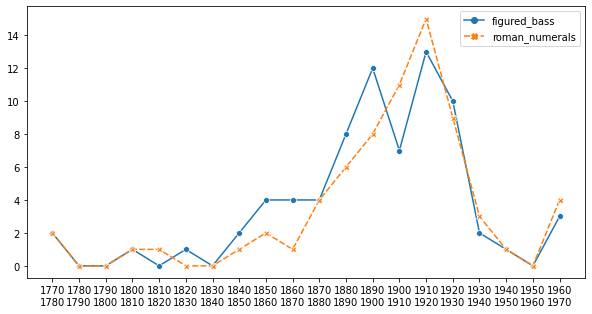

In [7]:
plt.figure(figsize=(10, 5))
g = sns.lineplot(data=dfplot, markers=True)
g.set_xticks(range(len(dfplot["period"])))
g.set_xticklabels(dfplot["period"])